# Notebook: run calibration

## Preamble

### Import packages

In [1]:
# We import standard Python libraries
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import Image

# We also import our own packages
import inputs.data as inpdt
import inputs.parameters_and_options as inpprm
import equilibrium.compute_equilibrium as eqcmp
import equilibrium.functions_dynamic as eqdyn
import calibration.calib_main_func as calmain
import outputs.export_outputs as outexp

### Define file paths

This corresponds to the architecture described in the README file
(introduction tab of the documentation): the data folder is not hosted
on the Github repository and should be placed in the root folder enclosing
the repo

In [2]:
path_code = '..'
path_folder = path_code + '/Data/'
path_precalc_inp = path_folder + 'Precalculated inputs/'
path_data = path_folder + 'data_Cape_Town/'
path_precalc_transp = path_folder + 'precalculated_transport/'
path_scenarios = path_data + 'Scenarios/'
path_outputs = path_code + '/Output/'
path_floods = path_folder + "FATHOM/"
path_input_plots = path_outputs + '/input_plots/'
path_input_tables = path_outputs + '/input_tables/'

### Create associated directories if needed

In [3]:
try:
    os.mkdir(path_input_plots)
except OSError as error:
    print(error)

try:
    os.mkdir(path_input_tables)
except OSError as error:
    print(error)

[WinError 183] Cannot create a file when that file already exists: '../Output//input_plots/'
[WinError 183] Cannot create a file when that file already exists: '../Output//input_tables/'


## Import parameters and options

### We import default parameter and options

In [4]:
import inputs.parameters_and_options as inpprm
options = inpprm.import_options()
param = inpprm.import_param(
    path_precalc_inp, options)

### We also set custom options for this simulation

#### We first set options regarding structural assumptions used in the model

In [5]:
# Dummy for taking floods into account in agents' choices
options["agents_anticipate_floods"] = 1
# Dummy for preventing new informal settlement development
options["informal_land_constrained"] = 0

#### Then we set options regarding flood data used

In [6]:
# Dummy for taking pluvial floods into account (on top of fluvial floods)
options["pluvial"] = 1
# Dummy for reducing pluvial risk for (better protected) formal structures
options["correct_pluvial"] = 1
# Dummy for taking coastal floods into account (on top of fluvial floods)
options["coastal"] = 1
# Digital elevation model to be used with coastal floods (MERITDEM or NASADEM)
# NB: MERITDEM is also the DEM used for fluvial and pluvial flood data
options["dem"] = "MERITDEM"
# Dummy for taking defended (vs. undefended) fluvial flood maps
# NB: FATHOM recommends to use undefended maps due to the high uncertainty
# in infrastructure modelling
options["defended"] = 0
# Dummy for taking sea-level rise into account in coastal flood data
# NB: Projections are up to 2050, based upon IPCC AR5 assessment for the
# RCP 8.5 scenario
options["slr"] = 1

#### We also set options for scenarios on time-moving exogenous variables

In [7]:
# NB: Must be set to 1/2/3 for low/medium/high growth scenario
options["inc_ineq_scenario"] = 2
options["pop_growth_scenario"] = 3
options["fuel_price_scenario"] = 2

#### Finally, we set options regarding data processing

Default is set at zero to save computing time
(data is simply loaded in the model)

NB: this is only needed to create the data for the first time, or when the
source is changed, so that pre-processed data is updated

In [8]:
# Dummy for converting small-area-level (SAL) data into grid-level data
# (used for result validation)
options["convert_sal_data"] = 0
# Dummy for computing expected income net of commuting costs on the basis
# of calibrated wages
options["compute_net_income"] = 0

## Load data

### Basic geographic data

In [9]:
import inputs.data as inpdt
grid, center = inpdt.import_grid(path_data)
amenities = inpdt.import_amenities(path_precalc_inp, options)
geo_grid = gpd.read_file(path_data + "grid_reference_500.shp")
geo_TAZ = gpd.read_file(path_data + "TAZ_ampp_prod_attr_2013_2032.shp")

### Macro data

In [10]:
import inputs.data as inpdt
(interest_rate, population, housing_type_data, total_RDP
 ) = inpdt.import_macro_data(param, path_scenarios, path_folder)

### Households and income data

In [11]:
import inputs.data as inpdt

income_class_by_housing_type = inpdt.import_hypothesis_housing_type()

(mean_income, households_per_income_class, average_income, income_mult,
 income_2011, households_per_income_and_housing
 ) = inpdt.import_income_classes_data(param, path_data)

# NB: we create this parameter to maintain money illusion in simulations
# (see eqsim.run_simulation function)
param["income_year_reference"] = mean_income

# Other data at SP (small place) level used for calibration and validation
(data_rdp, housing_types_sp, data_sp, mitchells_plain_grid_2011,
 grid_formal_density_HFA, threshold_income_distribution, income_distribution,
 cape_town_limits) = inpdt.import_households_data(path_precalc_inp)

# Import nb of households per pixel, by housing type (from SAL data)
# NB: RDP housing is included in formal, and there are both formal and informal
# backyards
if options["convert_sal_data"] == 1:
    housing_types = inpdt.import_sal_data(grid, path_folder, path_data,
                                          housing_type_data)
housing_types = pd.read_excel(path_folder + 'housing_types_grid_sal.xlsx')
housing_types[np.isnan(housing_types)] = 0

### Land use projections

In [12]:
# We import basic projections
import inputs.data as inpdt
(spline_RDP, spline_estimate_RDP, spline_land_RDP,
 spline_land_backyard, spline_land_informal, spline_land_constraints,
 number_properties_RDP) = (
     inpdt.import_land_use(grid, options, param, data_rdp, housing_types,
                           housing_type_data, path_data, path_folder)
     )

# We correct areas for each housing type at baseline year for the amount of
# constructible land in each type
import inputs.data as inpdt
coeff_land = inpdt.import_coeff_land(
    spline_land_constraints, spline_land_backyard, spline_land_informal,
    spline_land_RDP, param, 0)

# We import housing heigth limits
import inputs.data as inpdt
housing_limit = inpdt.import_housing_limit(grid, param)

# We update parameter vector with construction parameters
# (relies on loaded data) and compute other variables
import inputs.parameters_and_options as inpprm
(param, minimum_housing_supply, agricultural_rent
 ) = inpprm.import_construction_parameters(
    param, grid, housing_types_sp, data_sp["dwelling_size"],
    mitchells_plain_grid_2011, grid_formal_density_HFA, coeff_land,
    interest_rate, options
    )

### Import flood data (takes some time when agents anticipate floods)

In [13]:
# If agents anticipate floods, we return output from damage functions
import inputs.data as inpdt
if options["agents_anticipate_floods"] == 1:
    (fraction_capital_destroyed, structural_damages_small_houses,
     structural_damages_medium_houses, structural_damages_large_houses,
     content_damages, structural_damages_type1, structural_damages_type2,
     structural_damages_type3a, structural_damages_type3b,
     structural_damages_type4a, structural_damages_type4b
     ) = inpdt.import_full_floods_data(options, param, path_folder)

# Else, we set those outputs as zero
# NB: 24014 is the number of grid pixels
elif options["agents_anticipate_floods"] == 0:
    fraction_capital_destroyed = pd.DataFrame()
    fraction_capital_destroyed["structure_formal_2"] = np.zeros(24014)
    fraction_capital_destroyed["structure_formal_1"] = np.zeros(24014)
    fraction_capital_destroyed["structure_subsidized_2"] = np.zeros(24014)
    fraction_capital_destroyed["structure_subsidized_1"] = np.zeros(24014)
    fraction_capital_destroyed["contents_formal"] = np.zeros(24014)
    fraction_capital_destroyed["contents_informal"] = np.zeros(24014)
    fraction_capital_destroyed["contents_subsidized"] = np.zeros(24014)
    fraction_capital_destroyed["contents_backyard"] = np.zeros(24014)
    fraction_capital_destroyed["structure_backyards"] = np.zeros(24014)
    fraction_capital_destroyed["structure_formal_backyards"] = np.zeros(24014)
    fraction_capital_destroyed["structure_informal_backyards"
                               ] = np.zeros(24014)
    fraction_capital_destroyed["structure_informal_settlements"
                               ] = np.zeros(24014)

FU_5yr
FU_10yr
FU_20yr
FU_50yr
FU_75yr
FU_100yr
FU_200yr
FU_250yr
FU_500yr
FU_1000yr
P_5yr
P_10yr
P_20yr
P_50yr
P_75yr
P_100yr
P_200yr
P_250yr
P_500yr
P_1000yr
C_MERITDEM_1_0000
C_MERITDEM_1_0002
C_MERITDEM_1_0005
C_MERITDEM_1_0010
C_MERITDEM_1_0025
C_MERITDEM_1_0050
C_MERITDEM_1_0100
C_MERITDEM_1_0250
Contents in private formal
Contents in informal settlements
Contents in (any) backyard
Contents in formal subsidized
Private formal structures (one floor)
Private formal structures (two floors)
Formal subsidized structures (one floor)
Formal subsidized structures (two floors)
Informal settlement structures
Informal backyard structures
Formal backyard structures (one floor)
Formal backyard structures (two floors)


### Import scenarios (for time-moving variables)

In [14]:
import equilibrium.functions_dynamic as eqdyn
(spline_agricultural_rent, spline_interest_rate,
 spline_population_income_distribution, spline_inflation,
 spline_income_distribution, spline_population,
 spline_income, spline_minimum_housing_supply, spline_fuel
 ) = eqdyn.import_scenarios(income_2011, param, grid, path_scenarios,
                            options)

### Import income net of commuting costs (for all time periods)

In [15]:
import inputs.data as inpdt
if options["compute_net_income"] == 1:
    (incomeNetOfCommuting, modalShares, ODflows, averageIncome
     ) = inpdt.import_transport_data(
         grid, param, 0, households_per_income_class, average_income,
         spline_inflation, spline_fuel,
         spline_population_income_distribution, spline_income_distribution,
         path_precalc_inp, path_precalc_transp, 'GRID', options)

income_net_of_commuting_costs = np.load(
    path_precalc_transp + 'GRID_incomeNetOfCommuting_0.npy')

## Prepare data

### Define dominant income group in each census block (SP)

In [16]:
# In one case, we base our definition on the median income at the SP-level:
# we consider as dominant the group corresponding to the highest income
# threshold is crossed
if options["correct_dominant_incgrp"] == 0:
    data_income_group = np.zeros(len(data_sp["income"]))
    for j in range(0, param["nb_of_income_classes"] - 1):
        data_income_group[data_sp["income"] >
                          threshold_income_distribution[j]] = j+1

# In the other case, we just consider the most numerous income group in each
# census block
elif options["correct_dominant_incgrp"] == 1:
    data_income_group = np.zeros(len(income_distribution))
    for i in range(0, len(income_distribution)):
        data_income_group[i] = np.argmax(income_distribution[i])

Although the second option seems more logical, we take the first one as
default since we are going to consider median SP prices, and we want
associated net income to be in line with those values to avoid a sample
selection bias in our regressions.

### Obtain number of formal private housing units per SP

NB: it is not clear whether RDP are included in SP formal count, and
if they should be taken out based on imperfect cadastral estimations.
For reference, we include the two options.

In [17]:
if options["substract_RDP_from_formal"] == 1:
    # We retrieve number of RDP units per SP from grid-level data
    grid_intersect = pd.read_csv(path_data + 'grid_SP_intersect.csv',
                                 sep=';')
    # When pixels are associated to several SPs, we allocate them to the
    # one with the biggest intersection area.
    # NB: it would be more rigorous to split the number of RDP across
    # SPs according to their respective intersection areas, but this is
    # unlikely to change much
    grid_intersect = grid_intersect.groupby('ID_grille').max('Area')
    data_rdp["ID_grille"] = data_rdp.index
    data_rdp["ID_grille"] = data_rdp["ID_grille"] + 1

    rdp_grid = pd.merge(data_rdp, grid_intersect, on="ID_grille",
                        how="outer")
    rdp_sp = rdp_grid.groupby('SP_CODE')['count'].sum()
    rdp_sp = rdp_sp.reset_index()
    rdp_sp = rdp_sp.rename(columns={'SP_CODE': 'sp_code'})
    # We just fill the list with unmatched SPs to get the full SP vector
    rdp_sp_fill = pd.merge(rdp_sp, data_sp['sp_code'], on="sp_code",
                           how="outer")
    rdp_sp_fill['count'] = rdp_sp_fill['count'].fillna(0)
    rdp_sp_fill = rdp_sp_fill.sort_values(by='sp_code')

    data_number_formal = (
        housing_types_sp.total_dwellings_SP_2011
        - housing_types_sp.backyard_SP_2011
        - housing_types_sp.informal_SP_2011
        - rdp_sp_fill['count'])

elif options["substract_RDP_from_formal"] == 0:
    data_number_formal = (
        housing_types_sp.total_dwellings_SP_2011
        - housing_types_sp.backyard_SP_2011
        - housing_types_sp.informal_SP_2011
        )

Given the uncertainty surrounding RDP counts, we take the second option as
default and prefer to rely on sample selection (see below) to exclude the SPs
where RDP housing is likely to drive most of our results

### Sample selection

As the relations we are going to estimate are only true for the
formal private sector, we exclude SPs in the bottom quintile of property
prices and for which more than 5% of households are reported to live in
informal housing (settlements + backyards). We also exclude "rural" SPs
(i.e., those that are large, with a small share than can be urbanized).

We also add options to consider other criteria, namely we offer to
exclude poorest income group (which is in effect crowded out from the
formal sector), as well as Mitchell's Plain (as its housing market is
very specific) and far-away land (for which we have few observations).

In [18]:
if options["correct_selected_density"] == 0:
    selected_density = (
        (data_sp["price"] > np.nanquantile(data_sp["price"], 0.2))
        & (data_number_formal
           > 0.95 * housing_types_sp.total_dwellings_SP_2011)
        & (data_sp["unconstrained_area"]
            < np.nanquantile(data_sp["unconstrained_area"], 0.8))
        & (data_sp["unconstrained_area"] > 0.6 * 1000000 * data_sp["area"])
        )

elif (options["correct_selected_density"] == 1
      and options["correct_mitchells_plain"] == 0):
    selected_density = (
        (data_sp["price"] > np.nanquantile(data_sp["price"], 0.2))
        & (data_number_formal
           > 0.95 * housing_types_sp.total_dwellings_SP_2011)
        & (data_sp["unconstrained_area"]
            < np.nanquantile(data_sp["unconstrained_area"], 0.8))
        & (data_sp["unconstrained_area"] > 0.6 * 1000000 * data_sp["area"])
        & (data_income_group > 0)
        & (data_sp["distance"] < 40)
        )

elif (options["correct_selected_density"] == 1
      and options["correct_mitchells_plain"] == 1):
    selected_density = (
        (data_sp["price"] > np.nanquantile(data_sp["price"], 0.2))
        & (data_number_formal
           > 0.95 * housing_types_sp.total_dwellings_SP_2011)
        & (data_sp["unconstrained_area"]
            < np.nanquantile(data_sp["unconstrained_area"], 0.8))
        & (data_sp["unconstrained_area"] > 0.6 * 1000000 * data_sp["area"])
        & (data_income_group > 0)
        & (data_sp["mitchells_plain"] == 0)
        & (data_sp["distance"] < 40)
        )

We pick the second choice as our default since it is more conservative than
the first, and less ad hoc than the third one.

## Calibrate construction function parameters

In [19]:
# We estimate construction function parameters based on a log-linearization
# of the housing market clearing condition
import calibration.calib_main_func as calmain
coeff_b, coeff_a, coeffKappa = calmain.estim_construct_func_param(
    options, param, data_sp, threshold_income_distribution,
    income_distribution, data_rdp, housing_types_sp,
    data_number_formal, data_income_group, selected_density,
    path_data, path_precalc_inp, path_folder)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     89.87
Date:                Fri, 23 Sep 2022   Prob (F-statistic):           4.10e-32
Time:                        12:45:21   Log-Likelihood:                -52.613
No. Observations:                 140   AIC:                             113.2
Df Residuals:                     136   BIC:                             125.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7633      0.981     -3.837      0.0

NB: The results are automatically saved for later use in simulations

In [20]:
# We update parameter vector
param["coeff_a"] = coeff_a
param["coeff_b"] = coeff_b
param["coeff_A"] = coeffKappa

# We print the calibrated values
print("coeff_a = " + str(param["coeff_a"]))
print("coeff_b = " + str(param["coeff_b"]))
print("coeff_A = " + str(param["coeff_A"]))

# We save them
# NB: coeff_a = 1 - coeff_b
np.save(path_precalc_inp + 'calibratedHousing_b.npy',
        param["coeff_b"])
np.save(path_precalc_inp + 'calibratedHousing_kappa.npy',
        param["coeff_A"])

coeff_a = 0.758489277045013
coeff_b = 0.241510722954987
coeff_A = 0.030595011996082885


## Calibrate incomes and gravity parameter

We scan values for the gravity parameter to estimate incomes as a
function of it. The value range is set by trial and error: the wider the
range you want to test, the longer. In principle, we should find a value
within a coarse interval before going to the finer level: this may require
several iterations if the underlying data changes.

NB: we do that as it is too long and complex to run a solver directly.

Then, we select the income-gravity pair that best fits the distribution
of commuters over distance from the CBD.

NB: we need to proceed in two steps as there is no separate identification
of the gravity parameter and the net incomes.

In [21]:
# We start by selecting the range over which we want to scan
if options["scan_type"] == "rough":
    list_lambda = 10 ** np.arange(0.40, 0.51, 0.05)
if options["scan_type"] == "normal":
    list_lambda = 10 ** np.arange(0.42, 0.441, 0.01)
if options["scan_type"] == "fine":
    list_lambda = 10 ** np.arange(0.427, 0.4291, 0.001)

In [22]:
# We then run the function that returns the calibrated outputs
import calibration.calib_main_func as calmain
(incomeCentersKeep, lambdaKeep, cal_avg_income, scoreKeep,
 bhattacharyyaDistances) = (
    calmain.estim_incomes_and_gravity(
        param, grid, list_lambda, households_per_income_class,
        average_income, income_distribution, spline_inflation, spline_fuel,
        spline_population_income_distribution, spline_income_distribution,
        path_data, path_precalc_inp, path_precalc_transp, options)
    )

Estimating for lambda =  2.673006408663311
incomes for group  0
 - max iteration reached - mean error 0.0006624700558935639
incomes for group  1
 - max iteration reached - mean error 0.0005235262734921129
incomes for group  2
 - max iteration reached - mean error 0.0002078651226041427
incomes for group  3
 - max iteration reached - mean error 0.07736566807365537
Estimating for lambda =  2.679168324819032
incomes for group  0
 - max iteration reached - mean error 0.0006656752480600432
incomes for group  1
 - max iteration reached - mean error 0.0005238922833288978
incomes for group  2
 - max iteration reached - mean error 0.00020713382723845457
incomes for group  3
 - max iteration reached - mean error 0.07737078820051123
Estimating for lambda =  2.685344445658507
incomes for group  0
 - max iteration reached - mean error 0.0006688967994940419
incomes for group  1
 - max iteration reached - mean error 0.000524258736779616
incomes for group  2
 - max iteration reached - mean error 0.0002

In [67]:
# We update the parameter vector
param["lambda"] = np.array(lambdaKeep)

# We print the calibrated values (when possible)
print("lambda = " + str(param["lambda"]))

# We save them
np.save(path_precalc_inp + 'lambdaKeep.npy',
        param["lambda"])
np.save(path_precalc_inp + 'incomeCentersKeep.npy',
        incomeCentersKeep)

lambda = 2.679168324819032


Note that incomes are fitted to reproduce the observed distribution of jobs
across income groups (in selected job centers), based on commuting choice
model.

### Let us first visualize inputs

In [24]:
# We import the employment data at the TAZ (transport zone) level
import outputs.export_outputs as outexp
jobsTable, selected_centers = outexp.import_employment_geodata(
    households_per_income_class, param, path_data)

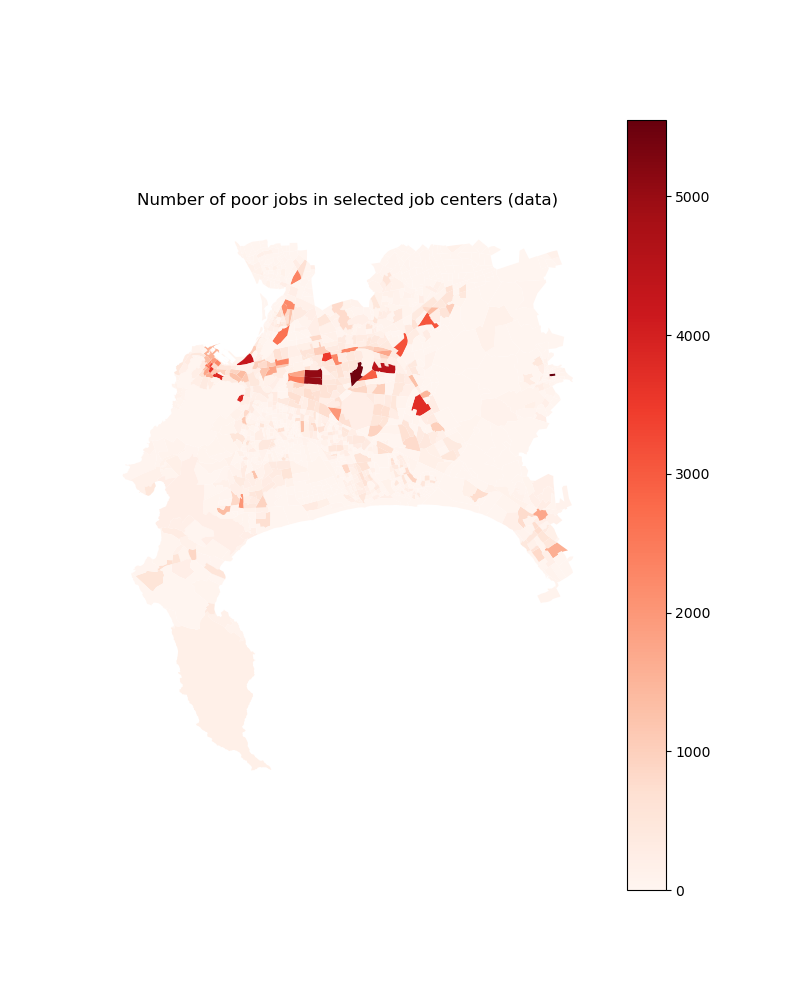

In [25]:
# Then, we visualize number of jobs for income group 1
jobs_poor_2d = pd.merge(geo_TAZ, jobsTable["poor_jobs"],
                        left_index=True, right_index=True)
jobs_poor_2d = pd.merge(jobs_poor_2d, selected_centers,
                        left_index=True, right_index=True)
jobs_poor_2d.drop('geometry', axis=1).to_csv(
    path_input_tables + 'jobs_poor' + '.csv')
jobs_poor_2d_select = jobs_poor_2d[
    (jobs_poor_2d.geometry.bounds.maxy < -3740000)
    & (jobs_poor_2d.geometry.bounds.maxx < -10000)].copy()
jobs_poor_2d_select.loc[
    jobs_poor_2d_select["selected_centers"] == 0, 'jobs_poor'
    ] = 0

fig, ax = plt.subplots(figsize=(8, 10))
ax.set_axis_off()
plt.title("Number of poor jobs in selected job centers (data)")
jobs_poor_2d_select.plot(column='poor_jobs', ax=ax,
                         cmap='Reds', legend=True)
plt.savefig(path_input_plots + 'jobs_poor_in_selected_centers')
plt.close()

Image(path_input_plots + "jobs_poor_in_selected_centers.png")

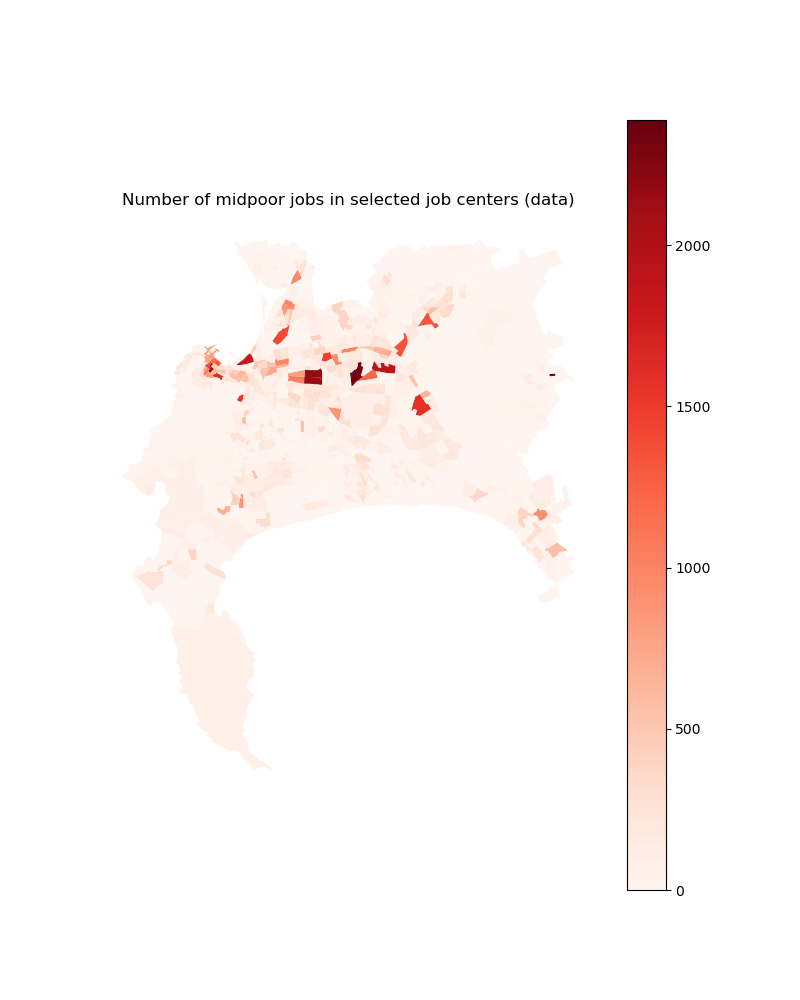

In [26]:
# Then for income group 2
jobs_midpoor_2d = pd.merge(geo_TAZ, jobsTable["midpoor_jobs"],
                           left_index=True, right_index=True)
jobs_midpoor_2d = pd.merge(jobs_midpoor_2d, selected_centers,
                           left_index=True, right_index=True)
# jobs_midpoor_2d.to_file(path_tables + 'jobs_midpoor' + '.shp')
jobs_midpoor_2d.drop('geometry', axis=1).to_csv(
    path_input_tables + 'jobs_midpoor' + '.csv')
jobs_midpoor_2d_select = jobs_midpoor_2d[
    (jobs_midpoor_2d.geometry.bounds.maxy < -3740000)
    & (jobs_midpoor_2d.geometry.bounds.maxx < -10000)].copy()
jobs_midpoor_2d_select.loc[
    jobs_midpoor_2d_select["selected_centers"] == 0, 'jobs_midpoor'
    ] = 0

fig, ax = plt.subplots(figsize=(8, 10))
ax.set_axis_off()
plt.title("Number of midpoor jobs in selected job centers (data)")
jobs_midpoor_2d_select.plot(column='midpoor_jobs', ax=ax,
                            cmap='Reds', legend=True)
plt.savefig(path_input_plots + 'jobs_midpoor_in_selected_centers')
plt.close()

Image(path_input_plots + "jobs_midpoor_in_selected_centers.png")

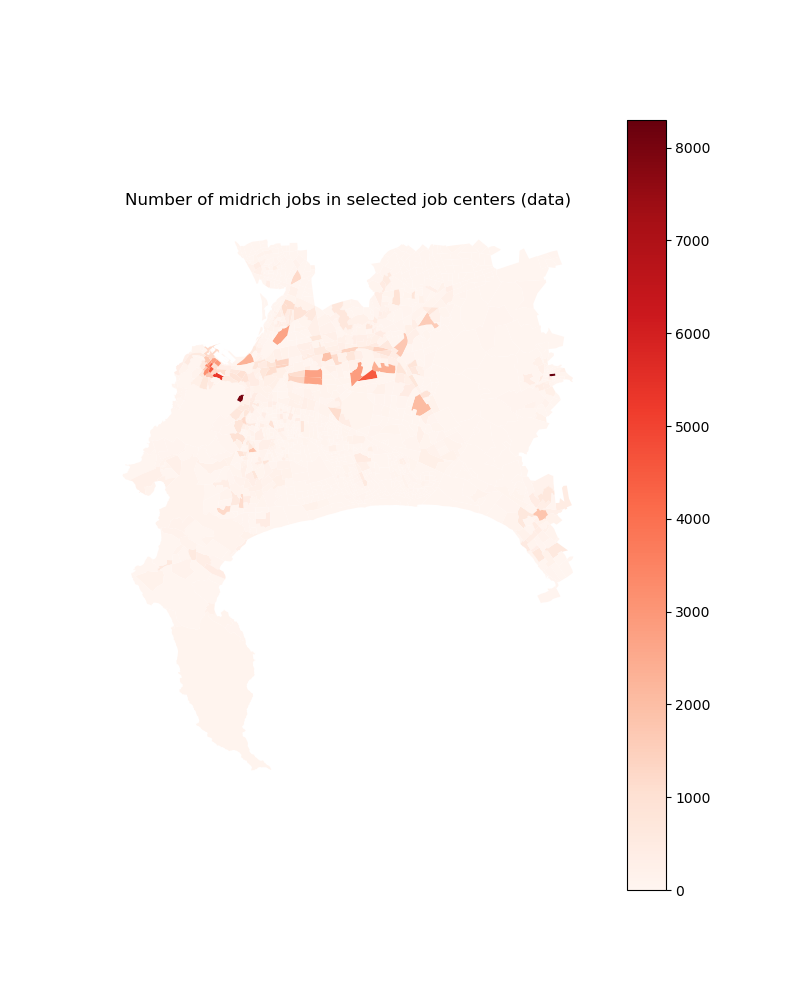

In [27]:
# For income group 3
jobs_midrich_2d = pd.merge(geo_TAZ, jobsTable["midrich_jobs"],
                           left_index=True, right_index=True)
jobs_midrich_2d = pd.merge(jobs_midrich_2d, selected_centers,
                           left_index=True, right_index=True)
# jobs_midrich_2d.to_file(path_tables + 'jobs_midrich' + '.shp')
jobs_midrich_2d.drop('geometry', axis=1).to_csv(
    path_input_tables + 'jobs_midrich' + '.csv')
jobs_midrich_2d_select = jobs_midrich_2d[
    (jobs_midrich_2d.geometry.bounds.maxy < -3740000)
    & (jobs_midrich_2d.geometry.bounds.maxx < -10000)].copy()
jobs_midrich_2d_select.loc[
    jobs_midrich_2d_select["selected_centers"] == 0, 'jobs_midrich'
    ] = 0

fig, ax = plt.subplots(figsize=(8, 10))
ax.set_axis_off()
plt.title("Number of midrich jobs in selected job centers (data)")
jobs_midrich_2d_select.plot(column='midrich_jobs', ax=ax,
                            cmap='Reds', legend=True)
plt.savefig(path_input_plots + 'jobs_midrich_in_selected_centers')
plt.close()

Image(path_input_plots + "jobs_midrich_in_selected_centers.png")

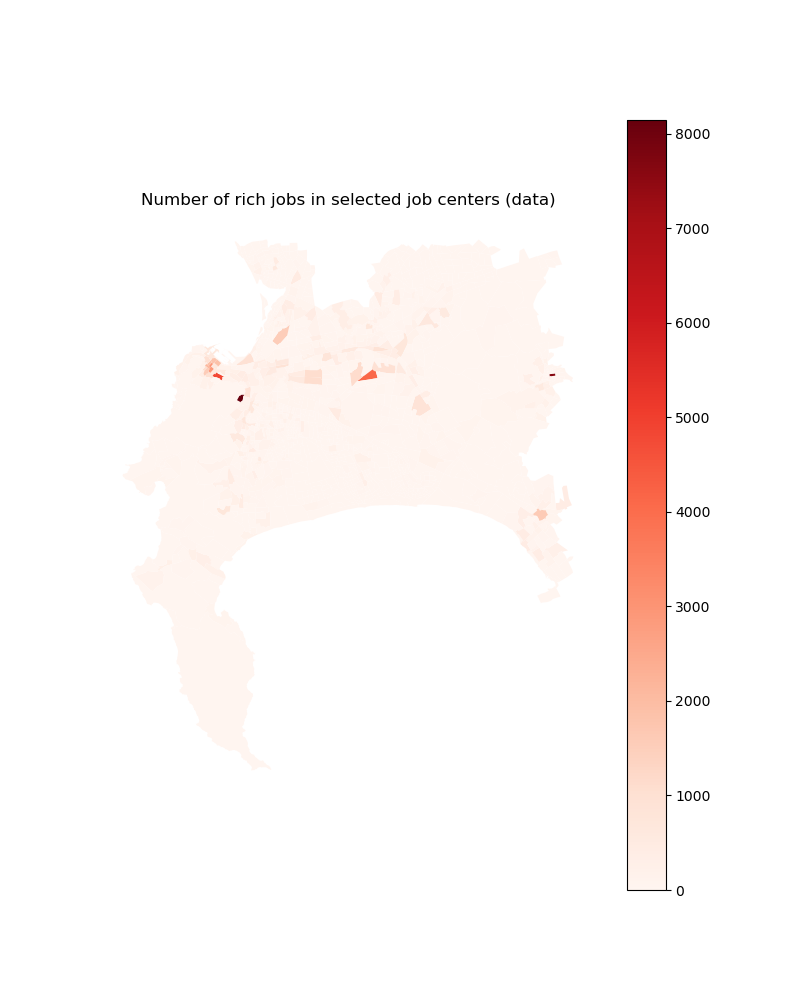

In [28]:
# For income group 4
jobs_rich_2d = pd.merge(geo_TAZ, jobsTable["rich_jobs"],
                        left_index=True, right_index=True)
jobs_rich_2d = pd.merge(jobs_rich_2d, selected_centers,
                        left_index=True, right_index=True)
# jobs_rich_2d.to_file(path_tables + 'jobs_rich' + '.shp')
jobs_rich_2d.drop('geometry', axis=1).to_csv(
    path_input_tables + 'jobs_rich' + '.csv')
jobs_rich_2d_select = jobs_rich_2d[
    (jobs_rich_2d.geometry.bounds.maxy < -3740000)
    & (jobs_rich_2d.geometry.bounds.maxx < -10000)].copy()
jobs_rich_2d_select.loc[
    jobs_rich_2d_select["selected_centers"] == 0, 'jobs_rich'
    ] = 0

fig, ax = plt.subplots(figsize=(8, 10))
ax.set_axis_off()
plt.title("Number of rich jobs in selected job centers (data)")
jobs_rich_2d_select.plot(column='rich_jobs', ax=ax,
                         cmap='Reds', legend=True)
plt.savefig(path_input_plots + 'jobs_rich_in_selected_centers')
plt.close()

Image(path_input_plots + "jobs_rich_in_selected_centers.png")

### We visualize the associated calibrated outputs

In [68]:
# We first load and rearrange the data that we just computed
income_centers_init = np.load(
    path_precalc_inp + 'incomeCentersKeep.npy')
income_centers_init[income_centers_init < 0] = 0
income_centers_init_merge = pd.DataFrame(income_centers_init)
income_centers_init_merge = income_centers_init_merge.rename(
    columns={income_centers_init_merge.columns[0]: 'poor_income',
             income_centers_init_merge.columns[1]: 'midpoor_income',
             income_centers_init_merge.columns[2]: 'midrich_income',
             income_centers_init_merge.columns[3]: 'rich_income'})
income_centers_init_merge["count"] = income_centers_init_merge.index + 1

In [69]:
# We prepare, execute, and clean the merge with geographic grid
selected_centers_merge = selected_centers.copy()
(selected_centers_merge["count"]
 ) = selected_centers_merge.selected_centers.cumsum()
selected_centers_merge.loc[
    selected_centers_merge.selected_centers == 0, "count"] = 0

income_centers_TAZ = pd.merge(income_centers_init_merge,
                              selected_centers_merge,
                              how='right', on='count')
income_centers_TAZ = income_centers_TAZ.fillna(value=0)

income_centers_2d = pd.merge(geo_TAZ, income_centers_TAZ,
                             left_index=True, right_index=True)
income_centers_2d.drop('geometry', axis=1).to_csv(
    path_input_tables + 'income_centers_2d' + '.csv')

income_centers_2d_select = income_centers_2d[
    (income_centers_2d.geometry.bounds.maxy < -3740000)
    & (income_centers_2d.geometry.bounds.maxx < -10000)].copy()

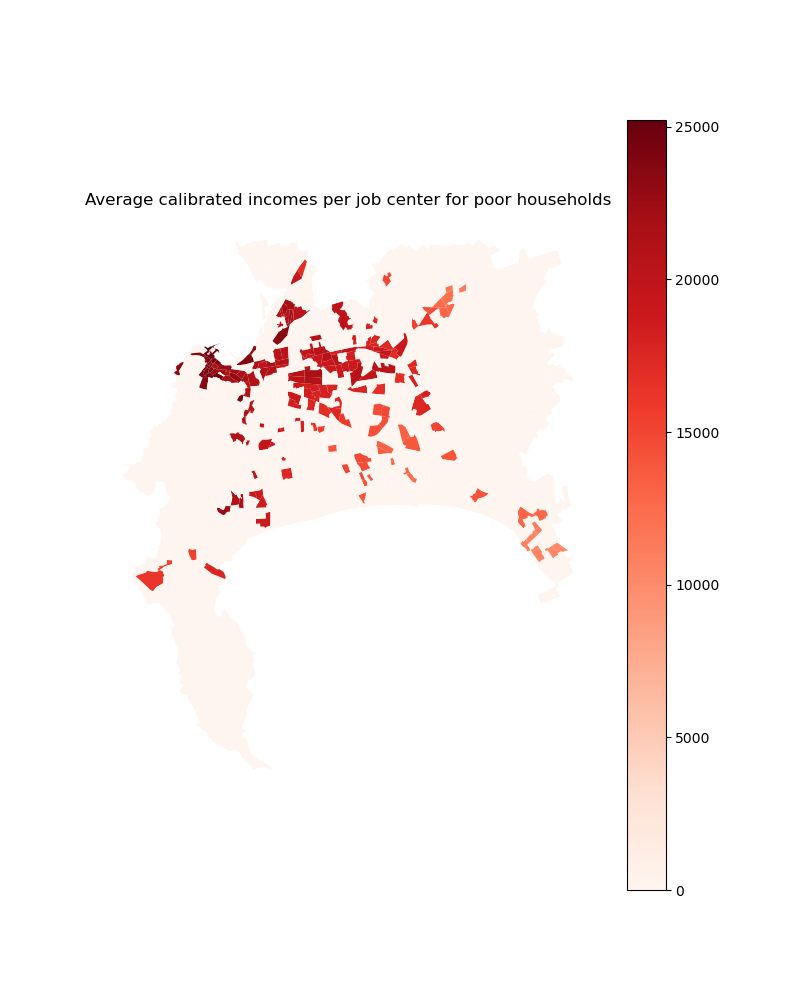

In [70]:
# We then visualize calibrated incomes for income group 1
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_axis_off()
plt.title("Average calibrated incomes per job center for poor households")
income_centers_2d_select.plot(column='poor_income', ax=ax,
                              cmap='Reds', legend=True)
plt.savefig(path_input_plots + 'poor_income_in_selected_centers')
plt.close()

Image(path_input_plots + "poor_income_in_selected_centers.png")

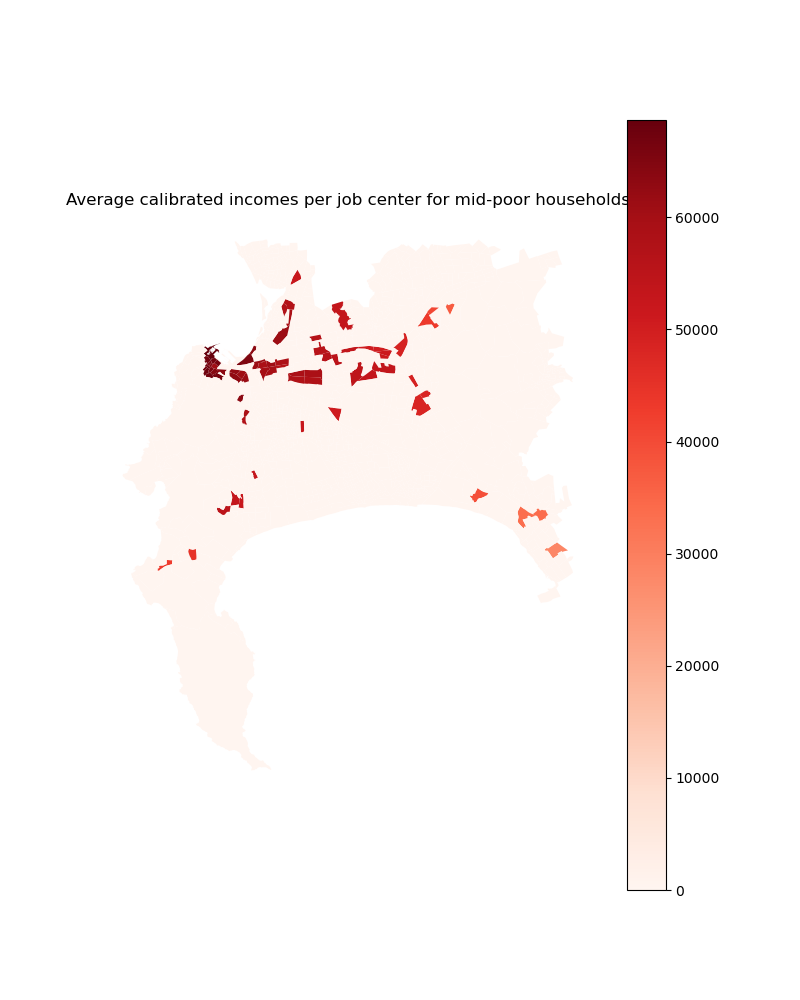

In [71]:
# For income group 2
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_axis_off()
plt.title("Average calibrated incomes per job center for mid-poor households")
income_centers_2d_select.plot(column='midpoor_income', ax=ax,
                              cmap='Reds', legend=True)
plt.savefig(path_input_plots + 'midpoor_income_in_selected_centers')
plt.close()

Image(path_input_plots + "midpoor_income_in_selected_centers.png")

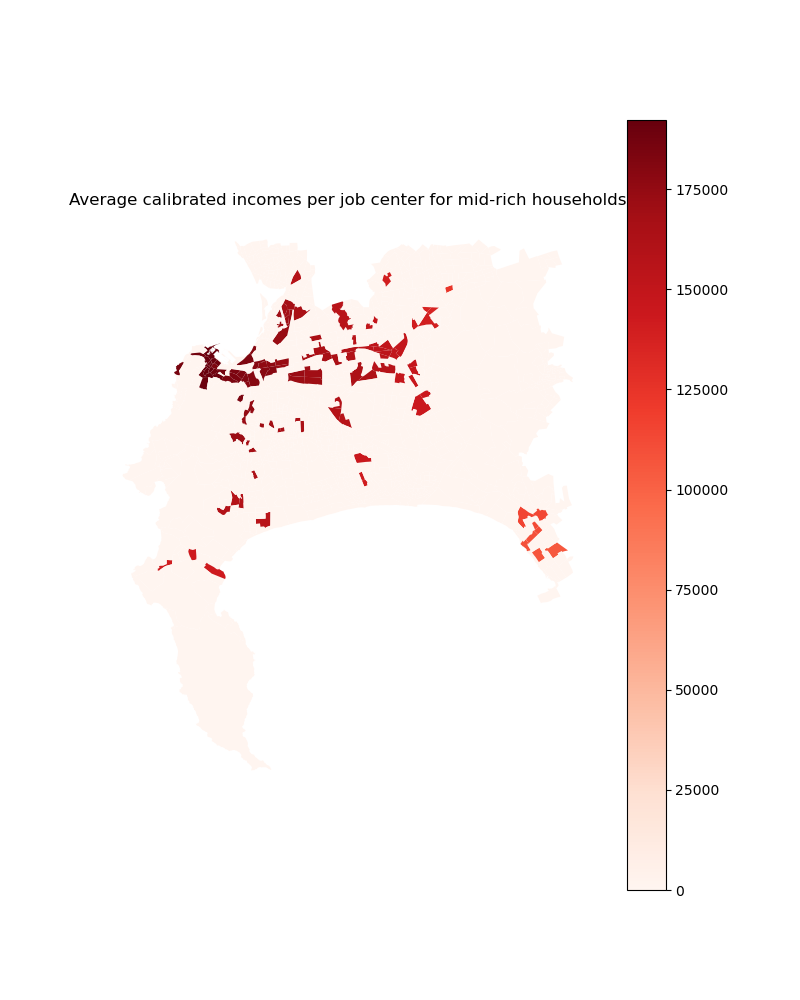

In [72]:
# For income group 3
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_axis_off()
plt.title("Average calibrated incomes per job center for mid-rich households")
income_centers_2d_select.plot(column='midrich_income', ax=ax,
                              cmap='Reds', legend=True)
plt.savefig(path_input_plots + 'midrich_income_in_selected_centers')
plt.close()

Image(path_input_plots + "midrich_income_in_selected_centers.png")

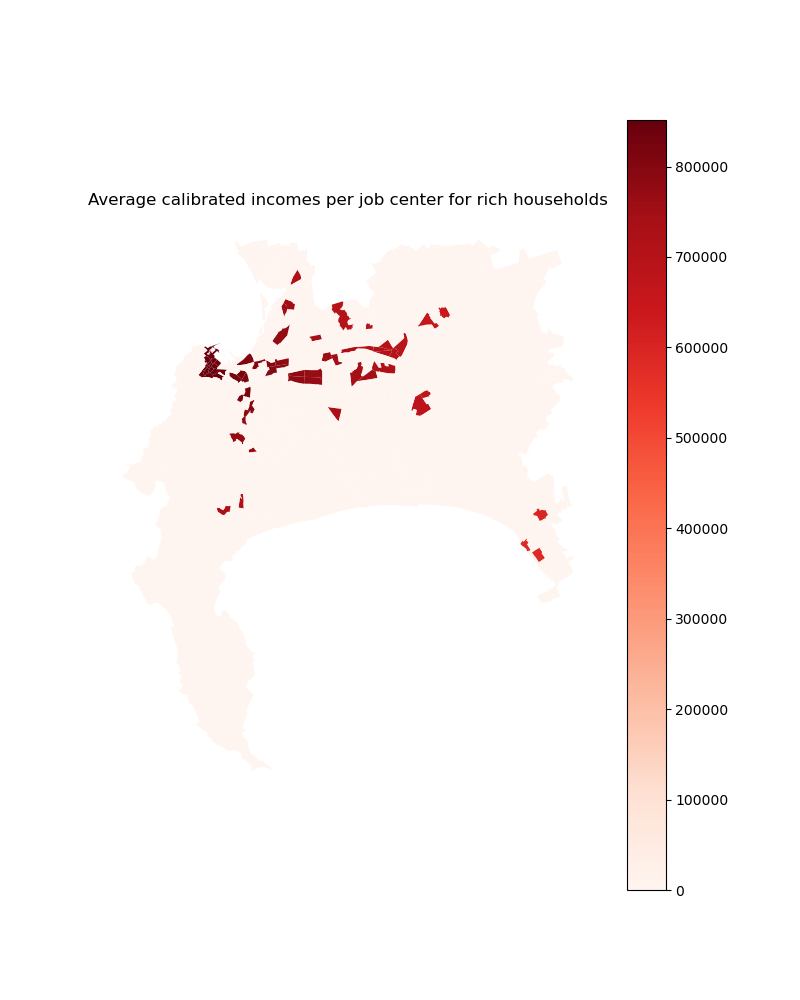

In [73]:
# For income group 4
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_axis_off()
plt.title("Average calibrated incomes per job center for rich households")
income_centers_2d_select.plot(column='rich_income', ax=ax,
                              cmap='Reds', legend=True)
plt.savefig(path_input_plots + 'rich_income_in_selected_centers')
plt.close()

Image(path_input_plots + "rich_income_in_selected_centers.png")

## Calibrate utility function parameters

We compute local incomes net of commuting costs at the SP (not grid)
level that is used in calibration.

In [74]:
# Note that lambda and calibrated incomes have an impact here: from now on,
# we will stop loading precalibrated parameters to rely on the newly
# calibrated parameters that we just saved
options["load_precal_param"] = 0

import inputs.data as inpdt
(incomeNetOfCommuting, *_
 ) = inpdt.import_transport_data(
     grid, param, 0, households_per_income_class, average_income,
     spline_inflation, spline_fuel,
     spline_population_income_distribution, spline_income_distribution,
     path_precalc_inp, path_precalc_transp, 'SP', options)

Then we calibrate utility function parameters based on the maximization
of a composite likelihood that reproduces the fit on exogenous amenities,
dwelling sizes, and income sorting.

In [75]:
# NB: Here, we also have an impact from construction parameters and sample
# selection (+ number of formal units)
import calibration.calib_main_func as calmain
(calibratedUtility_beta, calibratedUtility_q0, cal_amenities
 ) = calmain.estim_util_func_param(
     data_number_formal, data_income_group, housing_types_sp, data_sp,
     coeff_a, coeff_b, coeffKappa, interest_rate,
     incomeNetOfCommuting, selected_density, path_data, path_precalc_inp,
     options, param)


Done: 
0
1
2


C:\Users\monni\miniconda3\envs\doc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the additional knot would
coincide with an old one. Probable cause: s too small or too large
a weight to an inaccurate data point. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=8096 fp=4135075811199389978199064576.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\monni\miniconda3\envs\doc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the additional knot would
coincide with an old one. Probable cause: s too small or too large
a weight to an inaccurate data point. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=8096 fp=4151181453875466981517295616.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\monni\miniconda3\envs\doc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the additional k

3
4
5
6
7


C:\Users\monni\miniconda3\envs\doc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the additional knot would
coincide with an old one. Probable cause: s too small or too large
a weight to an inaccurate data point. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=8096 fp=4191866421404378334391959552.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\monni\miniconda3\envs\doc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the additional knot would
coincide with an old one. Probable cause: s too small or too large
a weight to an inaccurate data point. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=8096 fp=4198139653459922484067303424.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\monni\miniconda3\envs\doc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the additional k

8
9
10


C:\Users\monni\miniconda3\envs\doc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the additional knot would
coincide with an old one. Probable cause: s too small or too large
a weight to an inaccurate data point. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=8096 fp=4207806130058528315060256768.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\monni\miniconda3\envs\doc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the additional knot would
coincide with an old one. Probable cause: s too small or too large
a weight to an inaccurate data point. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=8096 fp=4211523109752039516105867264.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\monni\miniconda3\envs\doc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the additional k

11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274

Scanning complete


            

C:\Users\monni\miniconda3\envs\doc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the additional knot would
coincide with an old one. Probable cause: s too small or too large
a weight to an inaccurate data point. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=8096 fp=4175314171060144829827645440.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\monni\miniconda3\envs\doc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the additional knot would
coincide with an old one. Probable cause: s too small or too large
a weight to an inaccurate data point. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=8096 fp=4175314180967254769484693504.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\monni\miniconda3\envs\doc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the additional k

      fun: 430.5308837454141
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.68434189e-06, 5.68434192e-06, 5.68388505e-06, 5.68595342e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 5
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([2.60000000e-01, 3.97137219e+00, 1.44000000e+04, 6.72000000e+04])
*** Estimation of beta and q0 done ***
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     4.029
Date:                Wed, 21 Sep 2022   Prob (F-statistic):           6.98e-05
Time:                        18:21:57   Log-Likelihood:                 49.539
No. Observations:                 307   AIC:                            -79.08
Df Residuals:              

The warnings in the execution come from the fact that rent interpolation is discountinuous when underlying data is scattered. This is not a big issue to the extent that we are not interested in the shape of the rent function per se, but it causes optimization solver to break down when the associated likelihood function is not smooth. The calibration therefore essentially relies on parameter scanning.

In [77]:
# We update parameter vector
param["beta"] = calibratedUtility_beta
param["q0"] = calibratedUtility_q0

# We print calibrated values (when possible)
print("beta = " + str(param["beta"]))
print("q0 = " + str(param["q0"]))

# We save them
# NB : alpha = 1 - beta
np.save(path_precalc_inp + 'calibratedUtility_beta.npy',
        param["beta"])
np.save(path_precalc_inp + 'calibratedUtility_q0.npy',
        param["q0"])
np.save(path_precalc_inp + 'calibratedAmenities.npy',
        cal_amenities)

beta = 0.26
q0 = 3.9713721908703206


## Calibrate disamenity index for informal backyards + settlements

In [78]:
# We first need to recompute income net of commuting costs at baseline
# year since calibrated income has changed

import inputs.data as inpdt
(incomeNetOfCommuting, modalShares, ODflows, averageIncome
 ) = inpdt.import_transport_data(
     grid, param, 0, households_per_income_class, average_income,
     spline_inflation, spline_fuel,
     spline_population_income_distribution, spline_income_distribution,
     path_precalc_inp, path_precalc_transp, 'GRID', options)

income_net_of_commuting_costs = np.load(
    path_precalc_transp + 'GRID_incomeNetOfCommuting_0.npy')

In [79]:
# Then, we do the same for the amenity index (calibrated values normalized around 1)
import inputs.data as inpdt
amenities = inpdt.import_amenities(path_precalc_inp, options)

amenity_map done


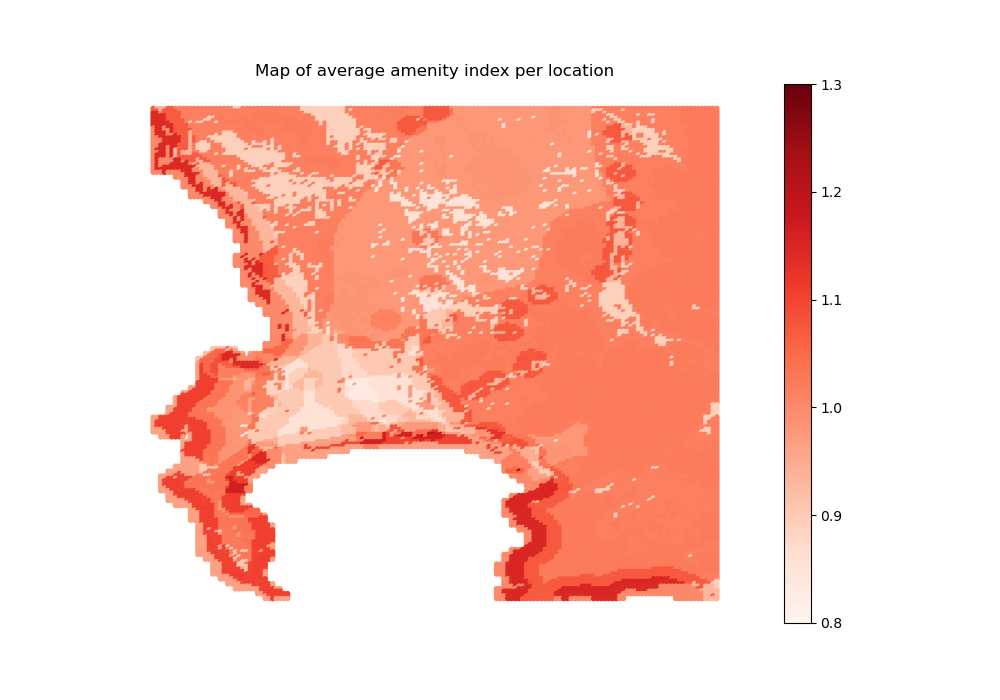

In [80]:
# Let us visualize the calibrated amenity index
import outputs.export_outputs as outexp
amenity_map = outexp.export_map(
    amenities, grid, geo_grid, path_input_plots, 'amenity_map',
    "Map of average amenity index per location",
    path_input_tables,
    ubnd=1.3, lbnd=0.8)

Image(path_input_plots + "amenity_map.png")

NB: Since disamenity index calibration relies on the model fit and is not
computed a priori (contrary to other parameters), the options set in the
preamble should be the same as the ones used in the main script, so that
the calibrated values are in line with the structural assumptions used

### We start with a general (not location-specific) calibration

In [81]:
# We define a range of disamenity values which we would like to scan,
# and arrange them in a grid
list_amenity_backyard = np.arange(0.62, 0.661, 0.01)
list_amenity_settlement = np.arange(0.60, 0.641, 0.01)
housing_type_total = pd.DataFrame(np.array(np.meshgrid(
    list_amenity_backyard, list_amenity_settlement)).T.reshape(-1, 2))
housing_type_total.columns = ["param_backyard", "param_settlement"]

In [82]:
# We initialize output vector
housing_type_total["formal"] = np.zeros(
    len(housing_type_total.param_backyard))
housing_type_total["backyard"] = np.zeros(
    len(housing_type_total.param_backyard))
housing_type_total["informal"] = np.zeros(
    len(housing_type_total.param_backyard))
housing_type_total["subsidized"] = np.zeros(
    len(housing_type_total.param_backyard))

In [83]:
# We print the number of total iterations (to have an intuition of how long
# the process will take)
number_total_iterations = (
    len(list_amenity_backyard) * len(list_amenity_settlement))
print(f"** Calibration: {number_total_iterations} iterations **")

** Calibration: 25 iterations **


We are going to compute the initial state equilibrium for each pair of
parameters, and retain the one that best fits the observed number of
households in informal settlements + backyards

In [84]:
import equilibrium.compute_equilibrium as eqcmp
for i in range(0, len(list_amenity_backyard)):
    for j in range(0, len(list_amenity_settlement)):

        # We set input values
        param["amenity_backyard"] = list_amenity_backyard[i]
        param["amenity_settlement"] = list_amenity_settlement[j]
        param["pockets"] = np.ones(24014) * param["amenity_settlement"]
        param["backyard_pockets"] = (np.ones(24014)
                                     * param["amenity_backyard"])

        # We run the algorithm
        (initial_state_utility,
         initial_state_error,
         initial_state_simulated_jobs,
         initial_state_households_housing_types,
         initial_state_household_centers,
         initial_state_households,
         initial_state_dwelling_size,
         initial_state_housing_supply,
         initial_state_rent,
         initial_state_rent_matrix,
         initial_state_capital_land,
         initial_state_average_income,
         initial_state_limit_city) = eqcmp.compute_equilibrium(
             fraction_capital_destroyed,
             amenities,
             param,
             housing_limit,
             population,
             households_per_income_class,
             total_RDP,
             coeff_land,
             income_net_of_commuting_costs,
             grid,
             options,
             agricultural_rent,
             interest_rate,
             number_properties_RDP,
             average_income,
             mean_income,
             income_class_by_housing_type,
             minimum_housing_supply,
             param["coeff_A"],
             income_2011)

        # We fill output matrix with the total number of HHs per housing
        # type for given values of backyard and informal amenity parameters
        housing_type_total.iloc[
            (housing_type_total.param_backyard
             == param["amenity_backyard"])
            & (housing_type_total.param_settlement
               == param["amenity_settlement"]),
            2:6] = np.nansum(initial_state_households_housing_types, 1)

        # We update the iteration count and print progress made
        iteration_number = i * len(list_amenity_settlement) + j + 1
        print(f"iteration {iteration_number}/{number_total_iterations}")

stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:40, 47.29it/s, error_max_abs=0.0182]


iteration 1/25


stops when error_max_abs <0.02:   4%|▉                         | 73/2000 [00:01<00:41, 46.10it/s, error_max_abs=0.0178]


iteration 2/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:40, 47.15it/s, error_max_abs=0.0182]


iteration 3/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:41, 47.02it/s, error_max_abs=0.0182]


iteration 4/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:41, 46.64it/s, error_max_abs=0.0182]


iteration 5/25


stops when error_max_abs <0.02:   4%|▉                         | 73/2000 [00:01<00:41, 46.51it/s, error_max_abs=0.0183]


iteration 6/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:41, 46.39it/s, error_max_abs=0.0182]


iteration 7/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:42, 45.77it/s, error_max_abs=0.0182]


iteration 8/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:42, 45.73it/s, error_max_abs=0.0182]


iteration 9/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:41, 46.52it/s, error_max_abs=0.0182]


iteration 10/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:41, 46.61it/s, error_max_abs=0.0182]


iteration 11/25


stops when error_max_abs <0.02:  70%|████████████████▊       | 1401/2000 [00:30<00:13, 45.96it/s, error_max_abs=0.0184]


iteration 12/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:41, 46.26it/s, error_max_abs=0.0182]


iteration 13/25


stops when error_max_abs <0.02:   4%|▉                         | 73/2000 [00:01<00:41, 46.29it/s, error_max_abs=0.0185]


iteration 14/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:42, 45.66it/s, error_max_abs=0.0182]


iteration 15/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:42, 45.46it/s, error_max_abs=0.0182]


iteration 16/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:44, 43.68it/s, error_max_abs=0.0182]


iteration 17/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:41, 46.00it/s, error_max_abs=0.0182]


iteration 18/25


stops when error_max_abs <0.02:   4%|▉                         | 74/2000 [00:01<00:42, 45.71it/s, error_max_abs=0.0168]


iteration 19/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:42, 45.58it/s, error_max_abs=0.0182]


iteration 20/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:42, 45.60it/s, error_max_abs=0.0199]


iteration 21/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:44, 43.76it/s, error_max_abs=0.0182]


iteration 22/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:43, 44.28it/s, error_max_abs=0.0182]


iteration 23/25


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:41, 46.03it/s, error_max_abs=0.0182]


iteration 24/25


stops when error_max_abs <0.02:   4%|█                         | 85/2000 [00:01<00:42, 45.58it/s, error_max_abs=0.0166]

iteration 25/25


In [85]:
# We compute the error between simulated and observed number of households
# in each housing type (without RDP, which is exogenously set equal to data)
distance_share = np.abs(
    housing_type_total.iloc[:, 2:5] - housing_type_data[None, 0:3])

# We define the score that we want to minimize as the sum of the errors for
# informal backyards and informal settlements
distance_share_score = (
    distance_share.iloc[:, 1] + distance_share.iloc[:, 2])

# We select the arguments associated with the minimum
which = np.argmin(distance_share_score)
min_score = np.nanmin(distance_share_score)
calibrated_amenities = housing_type_total.iloc[which, 0:2]

In [86]:
# We update parameter vector
param["amenity_backyard"] = calibrated_amenities[0]
param["amenity_settlement"] = calibrated_amenities[1]

# We print the calibrated values
print("amenity_backyard = " + str(param["amenity_backyard"]))
print("amenity_settlement = " + str(param["amenity_settlement"]))

# We save them
np.save(path_precalc_inp + 'param_amenity_backyard.npy',
        param["amenity_backyard"])
np.save(path_precalc_inp + 'param_amenity_settlement.npy',
        param["amenity_settlement"])

amenity_backyard = 0.64
amenity_settlement = 0.62


### Calibrate location-specific disamenity index

In [87]:
# Default is set to 1 but can be changed if we fear overfit of the model
import equilibrium.compute_equilibrium as eqcmp
if options["location_based_calib"] == 1:

    # We start from where we left (to gain time) and compute the
    # equilibrium again

    # We first initialize input values

    index = 0
    index_max = 50
    metrics = np.zeros(index_max)

    param["pockets"] = np.zeros(24014) + param["amenity_settlement"]
    save_param_informal_settlements = np.zeros((index_max, 24014))
    metrics_is = np.zeros(index_max)
    param["backyard_pockets"] = np.zeros(24014) + param["amenity_backyard"]
    save_param_backyards = np.zeros((index_max, 24014))
    metrics_ib = np.zeros(index_max)

    # We run the algorithm
    (initial_state_utility,
     initial_state_error,
     initial_state_simulated_jobs,
     initial_state_households_housing_types,
     initial_state_household_centers,
     initial_state_households,
     initial_state_dwelling_size,
     initial_state_housing_supply,
     initial_state_rent,
     initial_state_rent_matrix,
     initial_state_capital_land,
     initial_state_average_income,
     initial_state_limit_city
     ) = eqcmp.compute_equilibrium(
         fraction_capital_destroyed,
         amenities,
         param,
         housing_limit,
         population,
         households_per_income_class,
         total_RDP,
         coeff_land,
         income_net_of_commuting_costs,
         grid,
         options,
         agricultural_rent,
         interest_rate,
         number_properties_RDP,
         average_income,
         mean_income,
         income_class_by_housing_type,
         minimum_housing_supply,
         param["coeff_A"],
         income_2011)

    # We set the maximum number of iterations
    number_total_iterations = index_max

    # Then we optimize over the number of households per housing type
    # PER PIXEL, and not just on the aggregate number (to acccount for
    # differing disamenities per location, e.g. eviction probability,
    # infrastructure networks, etc.)

    # To do so, we use granular housing_types variable (from SAL data) instead
    # of aggregate housing_types variable

    for index in range(0, index_max):

        # INFORMAL SETTLEMENTS

        # We initialize output vector
        diff_is = np.zeros(24014)
        for i in range(0, 24014):
            # We store the error term
            diff_is[i] = (housing_types.informal_grid[i]
                          - initial_state_households_housing_types[2, :][i]
                          )
            # We apply an empirical reweighting that helps convergence
            adj = (diff_is[i] / 150000)
            # We increase the amenity score when we underestimate the nb of
            # households
            param["pockets"][i] = param["pockets"][i] + adj
        # We store iteration outcome and prevent extreme sorting from
        # happening due to the amenity score
        metrics_is[index] = sum(np.abs(diff_is))
        param["pockets"][param["pockets"] < 0.05] = 0.05
        param["pockets"][param["pockets"] > 0.99] = 0.99
        save_param_informal_settlements[index, :] = param["pockets"]

        # INFORMAL BACKYARDS

        # We initialize output vector
        diff_ib = np.zeros(24014)
        for i in range(0, 24014):
            # Note that we add an option depending on whether we restrict
            # ourselves to informal backyards (default) or all kinds of
            # backyards (not warranted given the standardized structure
            # assumed in the model)
            if options["actual_backyards"] == 1:
                diff_ib[i] = (
                    housing_types.backyard_informal_grid[i]
                    + housing_types.backyard_formal_grid[i]
                    - initial_state_households_housing_types[1, :][i])
            elif options["actual_backyards"] == 0:
                diff_ib[i] = (
                    housing_types.backyard_informal_grid[i]
                    - initial_state_households_housing_types[1, :][i])
            # We help convergence and update parameter
            adj = (diff_ib[i] / 75000)
            param["backyard_pockets"][i] = (
                param["backyard_pockets"][i] + adj)
        # We store iteration output and prevent extreme sorting
        metrics_ib[index] = sum(np.abs(diff_ib))
        param["backyard_pockets"][param["backyard_pockets"] < 0.05] = 0.05
        param["backyard_pockets"][param["backyard_pockets"] > 0.99] = 0.99
        save_param_backyards[index, :] = param["backyard_pockets"]

        # We retain the sum of the errors as our minimization objective
        metrics[index] = metrics_is[index] + metrics_ib[index]

        # We run the equilibrium again with updated values of
        # informal/backyard housing disamenity indices, then go to the next
        # iteration

        (initial_state_utility, initial_state_error,
         initial_state_simulated_jobs,
         initial_state_households_housing_types,
         initial_state_household_centers,
         initial_state_households, initial_state_dwelling_size,
         initial_state_housing_supply, initial_state_rent,
         initial_state_rent_matrix, initial_state_capital_land,
         initial_state_average_income, initial_state_limit_city
         ) = eqcmp.compute_equilibrium(
             fraction_capital_destroyed, amenities, param, housing_limit,
             population, households_per_income_class, total_RDP,
             coeff_land, income_net_of_commuting_costs, grid, options,
             agricultural_rent, interest_rate, number_properties_RDP,
             average_income, mean_income, income_class_by_housing_type,
             minimum_housing_supply, param["coeff_A"], income_2011)

        iteration_number = index + 1

        print(f"iteration {iteration_number}/{number_total_iterations}")

stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:43, 44.27it/s, error_max_abs=0.0182]


iteration 1/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:41, 46.93it/s, error_max_abs=0.0182]


iteration 2/50


stops when error_max_abs <0.02:   4%|▉                         | 73/2000 [00:01<00:41, 46.54it/s, error_max_abs=0.0178]


iteration 3/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:51, 37.74it/s, error_max_abs=0.0182]


iteration 4/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:40, 47.53it/s, error_max_abs=0.0195]


iteration 5/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:40, 47.62it/s, error_max_abs=0.0182]


iteration 6/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:43, 44.18it/s, error_max_abs=0.0182]


iteration 7/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:40, 47.20it/s, error_max_abs=0.0182]


iteration 8/50


stops when error_max_abs <0.02:  51%|████████████▏           | 1019/2000 [00:21<00:20, 46.95it/s, error_max_abs=0.0182]


iteration 9/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:41, 46.78it/s, error_max_abs=0.0182]


iteration 10/50


stops when error_max_abs <0.02:  13%|███▎                     | 265/2000 [00:05<00:36, 47.23it/s, error_max_abs=0.0197]


iteration 11/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:40, 47.61it/s, error_max_abs=0.0182]


iteration 12/50


stops when error_max_abs <0.02:  27%|██████▉                   | 537/2000 [00:11<00:31, 46.83it/s, error_max_abs=0.019]


iteration 13/50


stops when error_max_abs <0.02:  43%|██████████▋              | 851/2000 [00:18<00:24, 46.62it/s, error_max_abs=0.0164]


iteration 14/50


stops when error_max_abs <0.02:   8%|██▏                        | 162/2000 [00:03<00:39, 46.76it/s, error_max_abs=0.02]


iteration 15/50


stops when error_max_abs <0.02:  75%|█████████████████▉      | 1492/2000 [00:32<00:10, 46.45it/s, error_max_abs=0.0107]


iteration 16/50


stops when error_max_abs <0.02:  39%|█████████▍              | 782/2000 [00:16<00:26, 46.38it/s, error_max_abs=0.00188]


iteration 17/50


stops when error_max_abs <0.02:   4%|▉                         | 73/2000 [00:01<00:40, 47.08it/s, error_max_abs=0.0178]


iteration 18/50


stops when error_max_abs <0.02:  38%|█████████               | 753/2000 [00:16<00:27, 46.01it/s, error_max_abs=0.00287]


iteration 19/50


stops when error_max_abs <0.02:  27%|██████▌                 | 547/2000 [00:12<00:32, 45.02it/s, error_max_abs=0.00262]


iteration 20/50


stops when error_max_abs <0.02:  54%|████████████▍          | 1081/2000 [00:23<00:19, 46.18it/s, error_max_abs=0.00209]


iteration 21/50


stops when error_max_abs <0.02:  84%|████████████████████▏   | 1686/2000 [00:37<00:06, 45.51it/s, error_max_abs=0.0189]


iteration 22/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:41, 46.03it/s, error_max_abs=0.0182]


iteration 23/50


stops when error_max_abs <0.02:  22%|█████▋                    | 436/2000 [00:09<00:34, 45.14it/s, error_max_abs=0.013]


iteration 24/50


stops when error_max_abs <0.02:  39%|█████████▊               | 785/2000 [00:17<00:27, 44.93it/s, error_max_abs=0.0193]


iteration 25/50


stops when error_max_abs <0.02:  18%|████▎                   | 355/2000 [00:07<00:36, 44.90it/s, error_max_abs=0.00792]


iteration 26/50


stops when error_max_abs <0.02:  69%|████████████████▌       | 1376/2000 [00:30<00:13, 45.02it/s, error_max_abs=0.0189]


iteration 27/50


stops when error_max_abs <0.02:  30%|███████▍                 | 593/2000 [00:13<00:31, 44.21it/s, error_max_abs=0.0093]


iteration 28/50


stops when error_max_abs <0.02:  46%|███████████             | 918/2000 [00:20<00:24, 44.52it/s, error_max_abs=0.00797]


iteration 29/50


stops when error_max_abs <0.02:  37%|█████████▏               | 737/2000 [00:16<00:27, 45.15it/s, error_max_abs=0.0189]


iteration 30/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:42, 45.89it/s, error_max_abs=0.0182]


iteration 31/50


stops when error_max_abs <0.02:  87%|█████████████████████▋   | 1739/2000 [00:40<00:06, 42.47it/s, error_max_abs=0.013]


iteration 32/50


stops when error_max_abs <0.02:  42%|██████████▍              | 837/2000 [00:24<00:33, 34.43it/s, error_max_abs=0.0161]


iteration 33/50


stops when error_max_abs <0.02:  74%|█████████████████      | 1486/2000 [00:37<00:12, 39.69it/s, error_max_abs=0.00674]


iteration 34/50


stops when error_max_abs <0.02:  58%|██████████████▉           | 1151/2000 [00:26<00:19, 43.98it/s, error_max_abs=0.02]


iteration 35/50


stops when error_max_abs <0.02: 100%|███████████████████████▉| 1999/2000 [00:49<00:00, 40.36it/s, error_max_abs=0.0294]


iteration 36/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:47, 40.44it/s, error_max_abs=0.0182]


iteration 37/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:46, 41.53it/s, error_max_abs=0.0197]


iteration 38/50


stops when error_max_abs <0.02:  82%|████████████████████▍    | 1636/2000 [00:42<00:09, 38.53it/s, error_max_abs=0.011]


iteration 39/50


stops when error_max_abs <0.02:  36%|█████████                | 721/2000 [00:18<00:32, 39.84it/s, error_max_abs=0.0191]


iteration 40/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:47, 40.53it/s, error_max_abs=0.0182]


iteration 41/50


stops when error_max_abs <0.02:  51%|████████████▎           | 1028/2000 [00:40<00:38, 25.20it/s, error_max_abs=0.0118]


iteration 42/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:03<01:42, 18.81it/s, error_max_abs=0.0182]


iteration 43/50


stops when error_max_abs <0.02:  92%|█████████████████████▎ | 1848/2000 [01:00<00:04, 30.67it/s, error_max_abs=0.00641]


iteration 44/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:02<00:58, 33.00it/s, error_max_abs=0.0182]


iteration 45/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:02<00:57, 33.48it/s, error_max_abs=0.0182]


iteration 46/50


stops when error_max_abs <0.02:  41%|█████████▉              | 825/2000 [00:24<00:34, 34.25it/s, error_max_abs=0.00964]


iteration 47/50


stops when error_max_abs <0.02:  13%|███▎                     | 268/2000 [00:07<00:50, 34.12it/s, error_max_abs=0.0194]


iteration 48/50


stops when error_max_abs <0.02:   4%|▉                         | 72/2000 [00:01<00:53, 36.17it/s, error_max_abs=0.0182]


iteration 49/50


stops when error_max_abs <0.02:  11%|██▊                      | 224/2000 [00:06<00:52, 33.90it/s, error_max_abs=0.0199]


iteration 50/50
0.40678920836767085
0.6194845398082257
0.8039969236529559
0.4497641257277256
0.6393183222476003
0.9200420940045734
[WinError 183] Cannot create a file when that file already exists: '../Data/Precalculated inputs/'


In [93]:
# We pick the set of parameters that minimize the sum of absolute diffs
# between data and simulation
score_min = np.min(metrics)
index_min = np.argmin(metrics)

# We update the parameter vector
param["pockets"] = save_param_informal_settlements[index_min]
param["backyard_pockets"] = save_param_backyards[index_min]

# We save values
np.save(path_precalc_inp + 'param_pockets.npy',
        param["pockets"])
np.save(path_precalc_inp + 'param_backyards.npy',
        param["backyard_pockets"])

disamenity_IS_map done


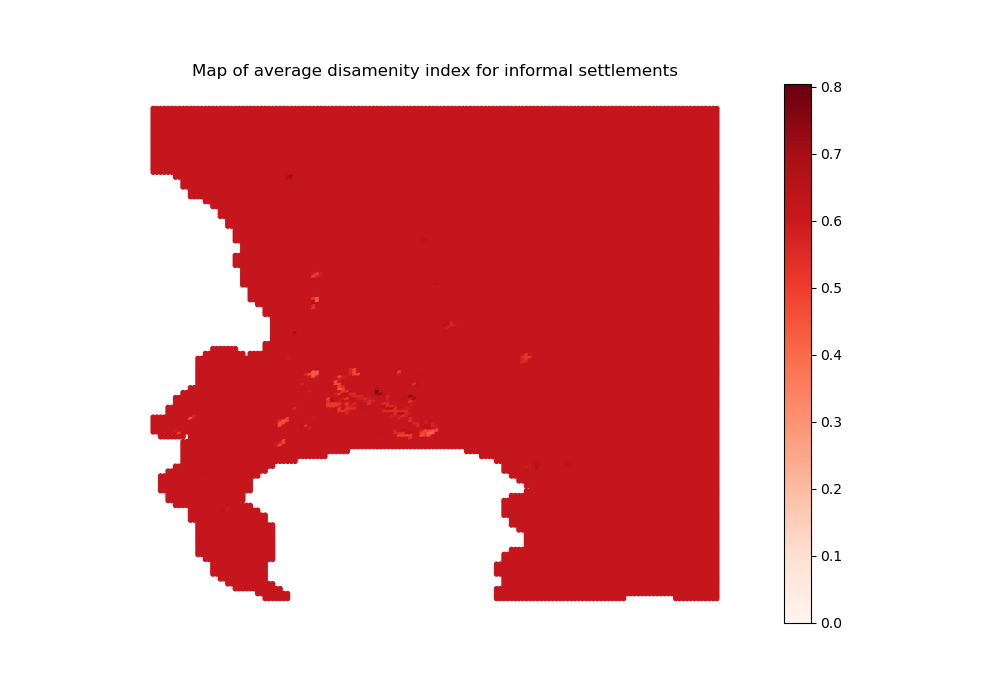

In [94]:
# Let us visualize the calibrated disamenity index for informal settlements
import outputs.export_outputs as outexp
disamenity_IS_map = outexp.export_map(
    param["pockets"], grid, geo_grid, path_input_plots, 'disamenity_IS_map',
    "Map of average disamenity index for informal settlements",
    path_input_tables, ubnd=np.nanmax(param["pockets"]))

Image(path_input_plots + "disamenity_IS_map.png")

disamenity_IB_map done


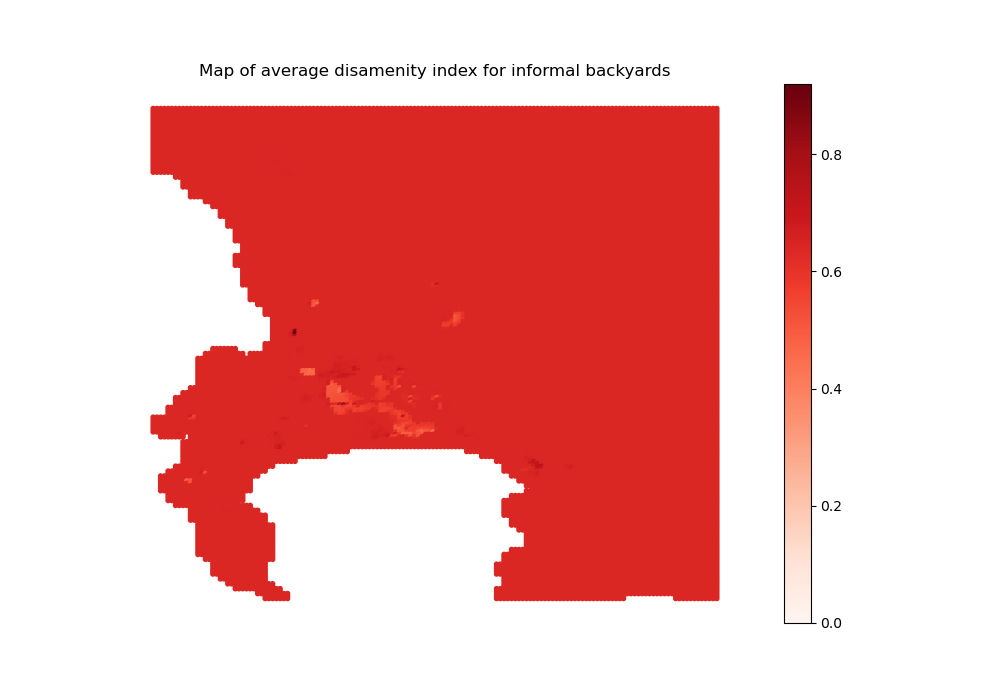

In [95]:
# Now for informal backyards
import outputs.export_outputs as outexp
disamenity_IB_map = outexp.export_map(
    param["backyard_pockets"], grid, geo_grid, path_input_plots, 'disamenity_IB_map',
    "Map of average disamenity index for informal backyards",
    path_input_tables, ubnd=np.nanmax(param["backyard_pockets"]))

Image(path_input_plots + "disamenity_IB_map.png")